---
---
# Turtle Recall: Conservation Challenge
### Can you build a facial recognition model... for turtles?


##### https://zindi.africa/competitions/turtle-recall-conservation-challenge
---


### INTRODUCTION

The aim of this competition is to build a machine learning model to identify individual sea turtles. For each image presented, the model should output the turtle's unique ID or, if the image corresponds to a new turtle (not present in the database), identify it as a new individual.

### DATASET OVERVIEW

The dataset provided with this challenge consists of the following files:
- `train.csv` containing 3 columns:
  - `image_id`: image identifier, mapping to `.JPG` image files located in the `IMAGES` subfolder.
  - `image_location`: this indicates whether the image is the left, right or top view of the turtle's face.
  - `turtle_id`: unique turtle identifier (what your model will be trained to predict given the image)
- `extra_images.csv` of turtle images containing 2 columns, `image_id` and `turtle_id`.
- `test.csv` contains test set image annotation with two columns `image_id` and `image_location`
  - Note that one possible outcome class is `new_turtle`, meaning that you may be asked to classify turtles that were not previously observed in the training set.
- `sample_submission.csv`: example submission file showing the 2 column format for submissions:
  - The first column is an `image_id`
  - The second column is a list of 5 `turtle_id` entries showing your top 5 predictions for the identity of the turtle shown in the image.

To get a sense of the data, here are a few examples from the training dataset:

<p align="center">
  <img src="https://storage.googleapis.com/dm-turtle-recall/tutorial_images/training_examples.png" width="600"/>
</p>

You can maybe already see some of the potential challenges inherent in this dataset!
- **Face positioning**. Turtle face pictures can be taken from 3 main angles, and even within a position category like "left", head position can vary.
- **Image dimensions**. Image dimensions and aspect ratios can vary, e.g. the "top" image is in tall format whereas the other three are in wide format.
- **Image quality**. The blurriness vs. sharpness of the images can vary

Looking through other images, you'll find other sources of diversity:
- Differences in backgrounds and lighting conditions
- Extraneous objects in the image such as hands, people in the background, and tags (not related to `turtle_id`)
- Turtles can have varying amounts of sand on their head

Here is a collage of some raw, unreshaped image samples from the training dataset:

<p align="center">
  <img src="https://storage.googleapis.com/dm-turtle-recall/tutorial_images/training_image_collage.png" width="800"/>
</p>

The challenge is to be able to recognise turtle faces despite the noise and confounding factors in the images!

---

## LETS GET STARTED!

#### In this notebook I have used SIFT, or Scale Invariant Feature Transform, a feature detection algorithm, to find features in each of the turtle images. For each image that needs to be recognised (query image / test image) I will get the features of that image using SIFT and compare those features to all features generated from a labeled turtle image (labelled image) using a matching algorithm. I will do this until I have compared the query image to all the labelled images. The images will then be ranked in order of similarity to the query image to get the 5 most similar images.

 
#### Basically I have attemped to implement the workflow from this paper: http://rajmadhan.myweb.usf.edu/sea_turtle.pdf

#### Big thanks to the author of the notebook contained in this repo https://github.com/adumrewal/SIFTImageSimilarity for sharing the code from which the skeleton of this notebook is constructed.

### Installs

In [1]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 1.5 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6 MB 1.3 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


### Getting the data

In [2]:
import os

SOURCE_URL = 'https://storage.googleapis.com/dm-turtle-recall/images.tar'
IMAGE_DIR = './turtle_recall/images'
TAR_PATH = os.path.join(IMAGE_DIR, os.path.basename(SOURCE_URL))
EXPECTED_IMAGE_COUNT = 13891

%sx mkdir --parents "{IMAGE_DIR}"
if len(os.listdir(IMAGE_DIR)) != EXPECTED_IMAGE_COUNT:
    %sx wget --no-check-certificate -O "{TAR_PATH}" "{SOURCE_URL}"
    %sx tar --extract --file="{TAR_PATH}" --directory="{IMAGE_DIR}"
    %sx rm "{TAR_PATH}"

print(f'The total number of images is: {len(os.listdir(IMAGE_DIR))}')

The total number of images is: 13891


### Imports

In [3]:
import sys

import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from joblib import parallel_backend, Parallel, delayed

import cv2 
import pickle
import matplotlib.pyplot as plt

import requests
import io
import urllib.parse

import gc
gc.enable()

### Reading the data

In [4]:
DEBUG = False
n,n2 = 10000,10000
if DEBUG:
    n,n2 = 700,100

BASE_URL = 'https://storage.googleapis.com/dm-turtle-recall/'

def read_csv_from_web(file_name):
    url = urllib.parse.urljoin(BASE_URL, file_name)
    content = requests.get(url).content
    return pd.read_csv(io.StringIO(content.decode('utf-8')))

# Read in csv files.
train = read_csv_from_web('train.csv')[:n]
test = read_csv_from_web('test.csv')[:n2]
sample_submission = read_csv_from_web('sample_submission.csv')[:n2]

# Convert image_location strings to lowercase.
for df in [train, test]:
    df.image_location = df.image_location.apply(lambda x: x.lower())
    assert set(df.image_location.unique()) == set(['left', 'right', 'top'])

train['image_id'] = train['image_id'].astype(str) + '.JPG'
test['image_id'] = test['image_id'].astype(str) + '.JPG'
sample_submission['image_id'] = sample_submission['image_id'].astype(str) + '.JPG'

In [5]:
display(train.head(),train.shape)
display(test.head(),test.shape)
display(sample_submission.head())

image_id image_location      turtle_id
0  ID_2RK4WLN8.JPG            top  t_id_VP2NW7aV
1  ID_VVW0QXLX.JPG           left  t_id_qZ0iZYsC
2  ID_RVATH2HZ.JPG          right  t_id_3b65X5Lw
3  ID_2GB90GPS.JPG           left  t_id_YjXYTCGC
4  ID_LM6S0B1M.JPG            top  t_id_d6aYXtor

(2145, 3)

image_id image_location
0  ID_6NEDKOYZ.JPG            top
1  ID_57QZ4S9N.JPG           left
2  ID_OCGGJS5X.JPG           left
3  ID_R2993S3S.JPG            top
4  ID_2E011NB0.JPG           left

(490, 2)

image_id prediction1    prediction2    prediction3 prediction4  \
0  ID_6NEDKOYZ.JPG  new_turtle  t_id_d6aYXtor  t_id_qZ0iZYsC  new_turtle   
1  ID_57QZ4S9N.JPG  new_turtle  t_id_d6aYXtor  t_id_qZ0iZYsC  new_turtle   
2  ID_OCGGJS5X.JPG  new_turtle  t_id_d6aYXtor  t_id_qZ0iZYsC  new_turtle   
3  ID_R2993S3S.JPG  new_turtle  t_id_d6aYXtor  t_id_qZ0iZYsC  new_turtle   
4  ID_2E011NB0.JPG  new_turtle  t_id_d6aYXtor  t_id_qZ0iZYsC  new_turtle   

     prediction5  
0  t_id_d6aYXtor  
1  t_id_d6aYXtor  
2  t_id_d6aYXtor  
3  t_id_d6aYXtor  
4  t_id_d6aYXtor

### Resize Images function

In [6]:
# Resize images to a similar dimension
# This helps improve accuracy and decreases unnecessarily high number of keypoints

def imageResizeTrain(image):
    maxD = 224
    height,width = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)

    # trim the edges of the image
    trim = 17
    h,w = image.shape
    image = image[-h+trim:h-trim,-w+trim:w-trim]

    return image

def imageResizeTest(image):
    maxD = 224
    height,width,channel = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)

    # trim the edges of the image
    trim = 17
    h,w,c = image.shape
    image = image[-h+trim:h-trim,-w+trim:w-trim]

    return image

## Generating Keypoints and Descriptors

### Prepare list of images

In [7]:
# The list will contain train and test images
imageList = train['image_id'].tolist() + test['image_id'].tolist()

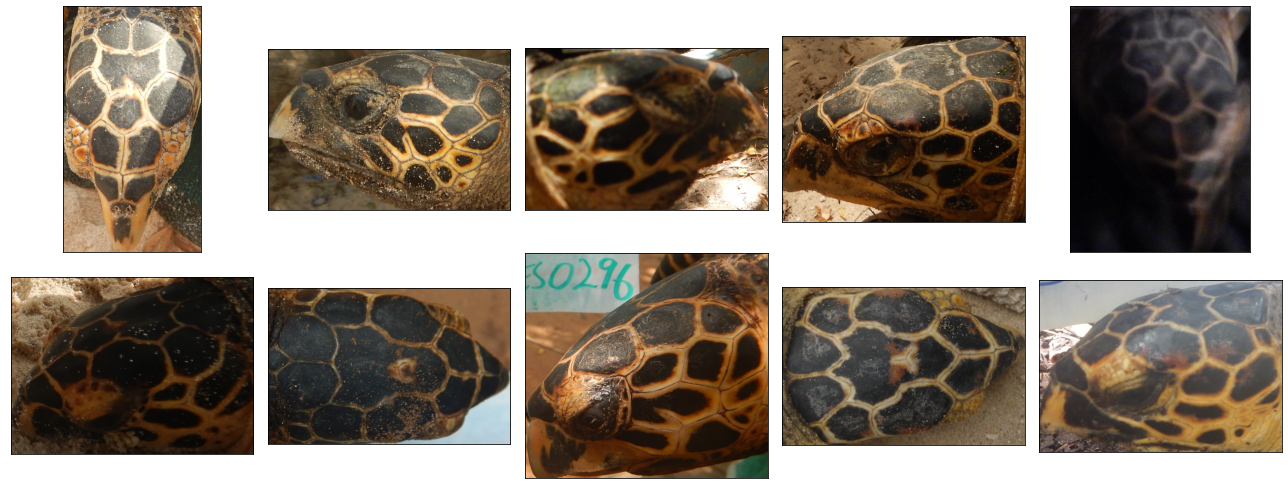

In [8]:
# Look at some of the images
SHOW = True
if SHOW:
    _, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 7))
    axes = axes.flatten()
    for img_id,ax in zip(imageList[:10],axes):
        imagePath = IMAGE_DIR+"/"+ str(img_id)
        img = cv2.imread(imagePath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.tight_layout()
    plt.show()

In [9]:
# We use grayscale images for generating keypoints
imagesBW = []
for imageName in tqdm(imageList):
    imagePath = IMAGE_DIR+"/"+ str(imageName)
    imagesBW.append(imageResizeTrain(cv2.imread(imagePath,0)))

100%|██████████| 2635/2635 [00:42<00:00, 61.89it/s]


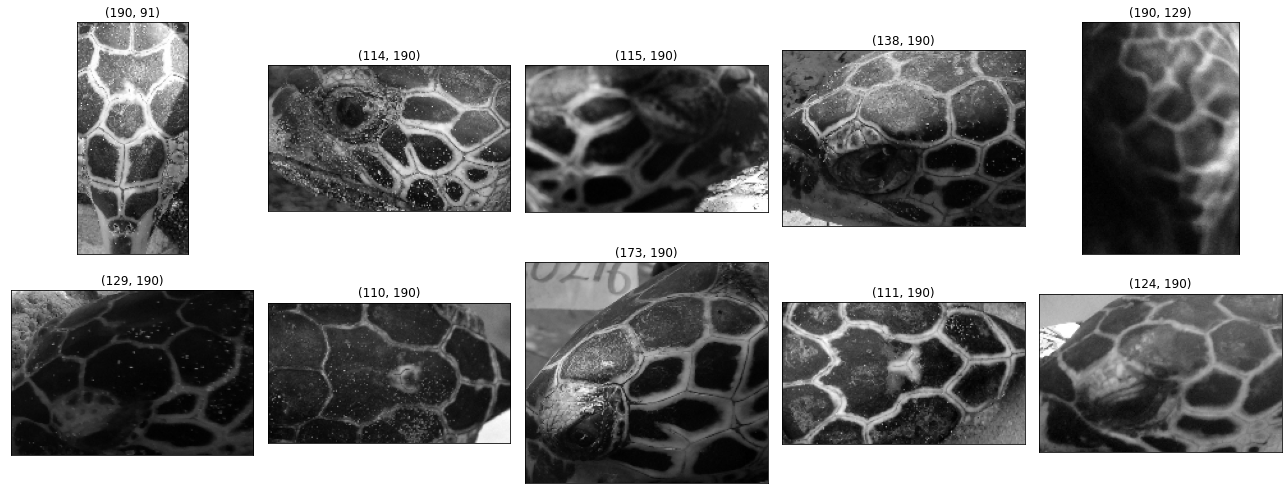

In [10]:
SHOW = True
if SHOW:
    _, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 7))
    axes = axes.flatten()
    for img,ax in zip(imagesBW[:10],axes):
        ax.imshow(img,cmap='gray')
        ax.set_title(img.shape)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.tight_layout()
    plt.show()

### SIFT

In [11]:
# The model can be ORB, SIFT, SURF, or any other image feature extraction model from open cv

sift = cv2.xfeatures2d.SIFT_create(edgeThreshold=5, sigma=1.5, contrastThreshold=0.03, nOctaveLayers=1)

def computeSIFT(image):
    return sift.detectAndCompute(image, None)

### The following is the main function to generate the keypoints and descriptors<br>

In [12]:
%%time
keypoints = []
descriptors = []

for image in tqdm(imagesBW):
    keypointTemp, descriptorTemp = computeSIFT(image)
    keypoints.append(keypointTemp)
    descriptors.append(descriptorTemp)

del imagesBW
gc.collect()
gc.collect()

100%|██████████| 2635/2635 [00:41<00:00, 63.60it/s]


CPU times: user 1min 3s, sys: 2.31 s, total: 1min 5s
Wall time: 41.6 s


### Store Keypoints and Descriptors for future use

In [13]:
# Create folders to store them
os.makedirs('/content/data',exist_ok=True)
os.makedirs('/content/data/keypoints',exist_ok=True)
os.makedirs('/content/data/descriptors',exist_ok=True)

In [14]:
%%time
i = 0
for keypoint in keypoints:
    deserializedKeypoints = []
    filepath = "data/keypoints/" + str(imageList[i].split('.')[0]) + ".txt"
    for point in keypoint:
        temp = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id)
        deserializedKeypoints.append(temp)
    with open(filepath, 'wb') as fp:
        pickle.dump(deserializedKeypoints, fp)    
    i += 1

i = 0
for descriptor in descriptors: 
    filepath = "data/descriptors/" + str(imageList[i].split('.')[0]) + ".txt"
    with open(filepath, 'wb') as fp:
        pickle.dump(descriptor, fp)
    i += 1

CPU times: user 480 ms, sys: 428 ms, total: 908 ms
Wall time: 931 ms


### Fetch Keypoints and Descriptors from stored files

In [15]:
def fetchKeypointFromFile(i):
    filepath = "data/keypoints/" + str(imageList[i].split('.')[0]) + ".txt"
    keypoint = []
    file = open(filepath,'rb')
    deserializedKeypoints = pickle.load(file)
    file.close()
    for point in deserializedKeypoints:
        temp = cv2.KeyPoint(x=point[0][0],y=point[0][1],_size=point[1], _angle=point[2], _response=point[3], _octave=point[4], _class_id=point[5])
        keypoint.append(temp)
    return keypoint

def fetchDescriptorFromFile(i):
    filepath = "data/descriptors/" + str(imageList[i].split('.')[0]) + ".txt"
    file = open(filepath,'rb')
    descriptor = pickle.load(file)
    file.close()
    return descriptor

# THE MATCHING BEGINS

### The main function to calculate results for any pair from the image list 

In [16]:
def calculateResultsFor(i,j, stats=False,MIN_MATCH_COUNT=3,scorebymatch=False):
    """
    i,j are indices from the image list. 
    This function returs a score representing how similar the images at i & j are.
    """
    
    # Reading in the keypoints/descriptors from the saved file takes too long, 
    # and the keypoints are already in memory in list variables so we'll just load them from there.
    keypoint1 = keypoints[i] #fetchKeypointFromFile(i)
    descriptor1 = descriptors[i] #fetchDescriptorFromFile(i)
    keypoint2 = keypoints[j] #fetchKeypointFromFile(j)
    descriptor2 = descriptors[j] #fetchDescriptorFromFile(j)

    # Getting the matches
    matches, filtered_matches = calculateMatches(descriptor1,descriptor2,keypoint1,keypoint2,MIN_MATCH_COUNT)

    if stats: 
        score1 = calculateScore(filtered_matches)
        score2 = calculateScore(matches)
        plot = getPlotFor(i,j,keypoint1,keypoint2,filtered_matches)
        print(f"ALL MATCHES: {len(matches)}\n",f"FILTERED MATCHES: {len(filtered_matches)}\n",
              len(keypoint1),len(keypoint2),len(descriptor1),len(descriptor2))
        print(f"SCORE FILTERD: {np.round(score1,5)}\n", f"SCORE: {np.round(score2,5)}")
        plt.imshow(plot),plt.show()

        return score1,score2,filtered_matches

    if scorebymatch:
        ## The more matches found the better
        return len(filtered_matches)

    else:
        score1 = calculateScore(filtered_matches)
        return score1

In [17]:
# The Image Matcher
bf = cv2.BFMatcher()

def calculateMatches(des1,des2,keypoint1,keypoint2,MIN_MATCH_COUNT):
    matches = bf.knnMatch(des1,des2,k=2)
    topResults1 = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            topResults1.append([m])
            
    matches = bf.knnMatch(des2,des1,k=2)
    topResults2 = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            topResults2.append([m])
    
    topResults = []
    for match1 in topResults1:
        match1QueryIndex = match1[0].queryIdx
        match1TrainIndex = match1[0].trainIdx

        for match2 in topResults2:
            match2QueryIndex = match2[0].queryIdx
            match2TrainIndex = match2[0].trainIdx

            if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
                topResults.append(match1)
    
    # Filter the matches by removing outlier matches.
    if len(topResults)>MIN_MATCH_COUNT:
        src_pts = np.float32([ keypoint1[m[0].queryIdx].pt for m in topResults ]).reshape(-1,1,2)
        dst_pts = np.float32([ keypoint2[m[0].trainIdx].pt for m in topResults ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,ransacReprojThreshold=7.0)
        matchesMask = mask.ravel().tolist()
        filtered_matches = [i for i,j in zip(topResults,matchesMask) if j==1]
    else:
        filtered_matches = topResults

    return topResults, filtered_matches

def getPlotFor(i,j,keypoint1,keypoint2,matches):
    image1 = imageResizeTest(cv2.imread(IMAGE_DIR+"/"+imageList[i]))
    image2 = imageResizeTest(cv2.imread(IMAGE_DIR+"/"+imageList[j]))
    return getPlot(image1,image2,keypoint1,keypoint2,matches)

def getPlot(image1,image2,keypoint1,keypoint2,matches):
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    matchPlot = cv2.drawMatchesKnn(image1,keypoint1,image2,keypoint2,matches,None,[255,255,255],flags=2)
    return matchPlot

### Scoring metric

##### How you compare the images based on returned matches from the open cv image matching algorithm is important. This is the metric we'll use to rank the images. I tried a few ways of calculating and improving the metrics but the best approach was the basic approach, and that was to only consider the number of matches found. This only works well when filtering out bad matches using cv2.findHomography.

In [18]:
def calculateScore(matches,keypoint1,keypoint2):
    # Logic: 
    ### if the number of matches found between the two images equals the number of keypoints in each image
    ### then the two imgaes are identical. (100 is the best score)
    # This metric doesn't fit for our case of turtle recognition because of how diiferent the same turtle may look in different images.
    return 100 * (matches/min(keypoint1,keypoint2))

def calculateScore(filtered_matches):
    # Logic:
    ### For each match found between query image and labelled image, sort them by distance. The smaller the disance,
    ### The more similar the images are. Only consider the top n matches. Get the log of the mean disance of top n matches.
    ### Add the inverse of the amount of matches found.
    ### The smaller the score the better.

    n = len(filtered_matches)
    score = 99.9

    if n>=1:
        # Sort them in the order of their distance.
        filtered_matches_ = sorted(filtered_matches, key = lambda x:x[0].distance)

        ds = [i[0].distance for i in filtered_matches_[:5]]
        score = np.log(np.mean(ds)+0.0001) + 1/n

    return score

### Sample Results

#### To visualise the macthes, set stats=True, and pass different indices of the same turtle from the train dataframe into the calculateResultsFor function.

ALL MATCHES: 5
 FILTERED MATCHES: 4
 141 150 141 150
SCORE FILTERD: 5.65053
 SCORE: 5.66633


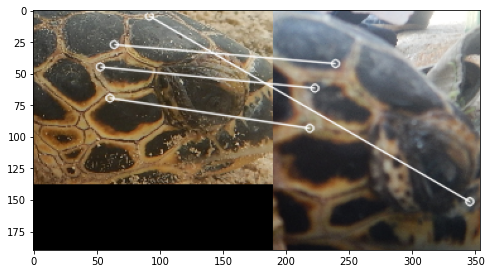

CPU times: user 346 ms, sys: 1.84 ms, total: 348 ms
Wall time: 693 ms


In [19]:
%%time
plt.figure(figsize=(8,8))
score1,score2,filtered_matches = calculateResultsFor(163,383, stats=True)

ALL MATCHES: 16
 FILTERED MATCHES: 13
 146 133 146 133
SCORE FILTERD: 5.06185
 SCORE: 5.00113


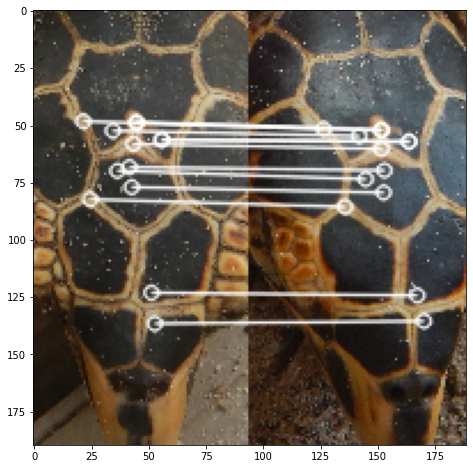

CPU times: user 364 ms, sys: 8.99 ms, total: 373 ms
Wall time: 374 ms


In [20]:
%%time
plt.figure(figsize=(8,8))
score1,score2,filtered_matches = calculateResultsFor(2028,2031, stats=True)

In [21]:
def plot_top_matches(K_,n=6):
    plt.figure(figsize=(5,5)) 
    imagePath = IMAGE_DIR+"/"+ K_
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    _, axes = plt.subplots(nrows=1, ncols=n, figsize=(18, 5))
    axes = axes.flatten()

    imids = results_df.image_id.values[:n]
    labels = results_df.turtle_id.values[:n]
    pos = results_df.image_location.values[:n]
    scores = results_df[K_].values[:n]

    for img_id,l,pos,score,ax in zip(imids,labels,pos,scores,axes):
        imagePath = IMAGE_DIR+"/"+ str(img_id)
        img = cv2.imread(imagePath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.set_title(f"{l} | {pos} | {np.round(score,4)}")
        ax.imshow(img)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.tight_layout()
    plt.show()

In [22]:
%%time
sample_inds = [2400,205,2146,2323,2401,2289,2290,808]
results = {}

for K in tqdm(sample_inds):
    K_ = imageList[K]
    results[K_] = {}
    for i in range(len(train)):
        score = calculateResultsFor(K,i,scorebymatch=True)
        results[K_][imageList[i]] = score

results_df = pd.DataFrame(results)
results_df.reset_index(inplace=True)
results_df.rename(columns={"index":"image_id"}, inplace=True)
results_df = results_df.merge(train,on="image_id",how="left")
display(results_df.head())

100%|██████████| 8/8 [00:46<00:00,  5.83s/it]


image_id  ID_1VQC9OXH.JPG  ID_X5IGA7ZC.JPG  ID_57QZ4S9N.JPG  \
0  ID_2RK4WLN8.JPG                1                4                2   
1  ID_VVW0QXLX.JPG                3                1                2   
2  ID_RVATH2HZ.JPG                1                1                0   
3  ID_2GB90GPS.JPG                4                2                0   
4  ID_LM6S0B1M.JPG                0                0                1   

   ID_9QND2AON.JPG  ID_8SG313I0.JPG  ID_2WPSSNRF.JPG  ID_2NQ6H59F.JPG  \
0                2                0                3                2   
1                2                3                3                1   
2                2                1                1                2   
3                1                1                0                1   
4                1                0                2                2   

   ID_CWWW0GH2.JPG image_location      turtle_id  
0                3            top  t_id_VP2NW7aV  
1                1           left  t_id_qZ0iZYsC  
2                0          right  t_id_3b65X5Lw  
3                5           left  t_id_YjXYTCGC  
4                2            top  t_id_d6aYXtor

CPU times: user 1min 28s, sys: 2.13 s, total: 1min 30s
Wall time: 46.7 s


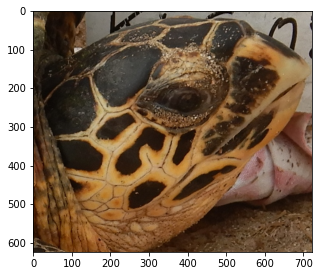

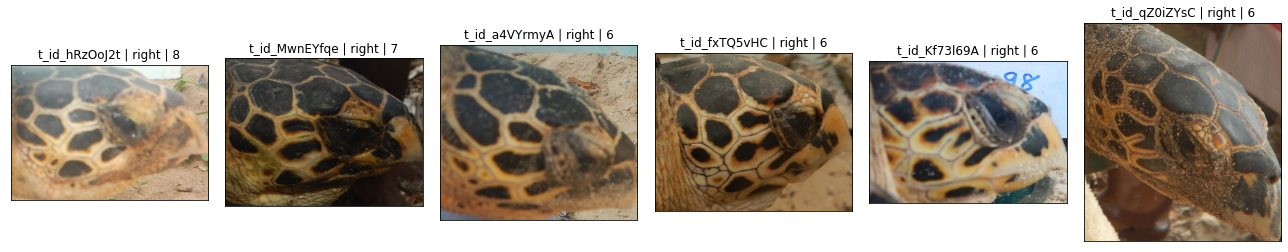

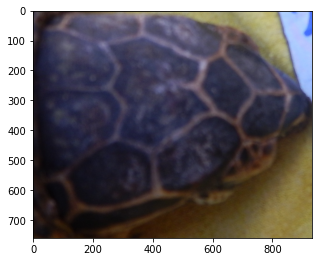

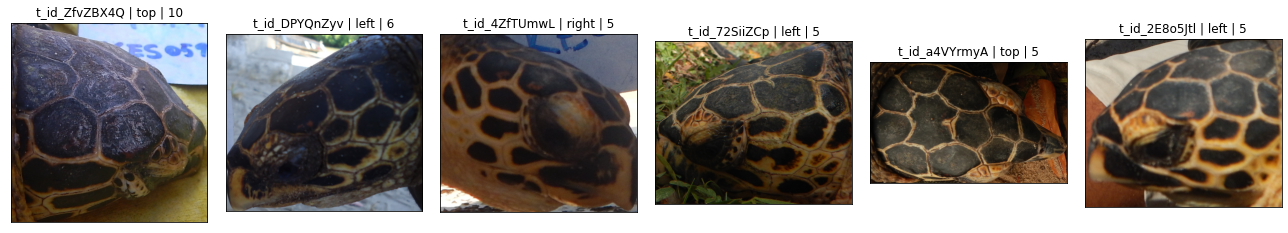

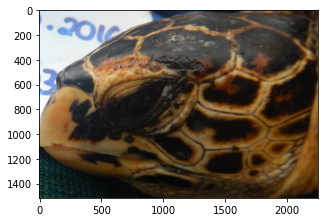

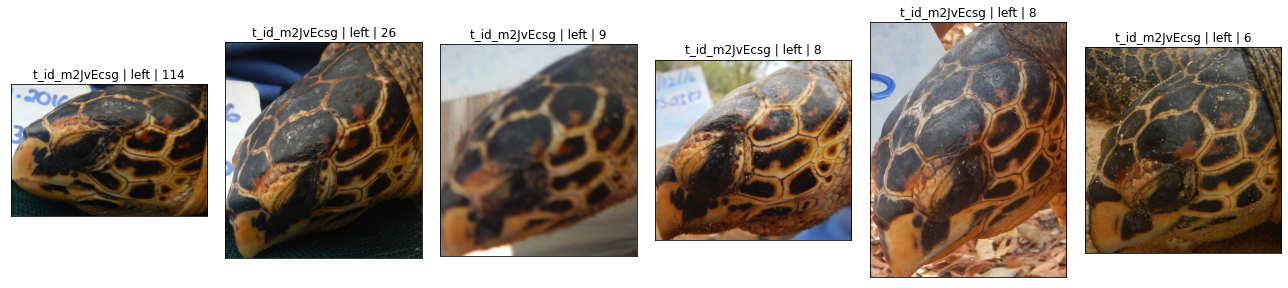

CPU times: user 6.74 s, sys: 477 ms, total: 7.22 s
Wall time: 6.78 s


In [23]:
%%time
SHOW = True
s = 3
if SHOW:
    for K in sample_inds[-s:]:
        K_ = imageList[K]
        results_df = results_df.sort_values(K_, ascending=False)
        plot_top_matches(K_)

## GET RESULTS FOR EACH TEST IMAGE

#### This takes quite a while to run, because it is comparing each test image against all train images. It takes roughly 17 sec to get results for a single test image. How long the search takes depends on the specific image algorithm used and number of keypoints/desciptors detected for each image.

In [24]:
%%time
test_inds = list(range(len(train),len(imageList)))
results = {}

for K in tqdm(test_inds):
    K_ = imageList[K]
    results[K_] = {}
    for i in range(len(train)):
        score = calculateResultsFor(K,i,scorebymatch=True)
        results[K_][imageList[i]] = score

results_df = pd.DataFrame(results)
results_df.reset_index(inplace=True)
results_df.rename(columns={"index":"image_id"}, inplace=True)
results_df = results_df.merge(train,on="image_id",how="left")
# Save the results
results_df.to_csv('TurtleSift.csv', index=False)

100%|██████████| 490/490 [49:03<00:00,  6.01s/it]


CPU times: user 1h 33min 11s, sys: 2min 7s, total: 1h 35min 19s
Wall time: 49min 4s


In [25]:
test_ids = sample_submission['image_id'].tolist()
preds = {}
# Only get the top 5 matches
for tid in tqdm(test_ids):
    results_df_ = results_df.copy()
    results_df_ = results_df_.sort_values(tid, ascending=False)
    results_df_ = results_df_.drop_duplicates(subset='turtle_id',keep='first')
    preds[tid] = results_df_['turtle_id'][:5].tolist()

100%|██████████| 490/490 [00:14<00:00, 34.48it/s]


In [26]:
sub = pd.DataFrame(preds).T
sub = sub.reset_index()
sub.columns = sample_submission.columns
sub.image_id = [i.replace('.JPG',"") for i in sub.image_id]
sub['prediction5'] = 'new_turtle'
sub.to_csv('TurtleSiftSub.csv', index=False) 
display(sub.head(),sub.shape)

image_id    prediction1    prediction2    prediction3    prediction4  \
0  ID_6NEDKOYZ  t_id_4ZfTUmwL  t_id_15bo4NKD  t_id_8b8sprYe  t_id_2E8o5Jtl   
1  ID_57QZ4S9N  t_id_Kf73l69A  t_id_3K93fQBS  t_id_2E8o5Jtl  t_id_8b8sprYe   
2  ID_OCGGJS5X  t_id_YjXYTCGC  t_id_AMnriNb5  t_id_gJaKYxBQ  t_id_dhdJMT1K   
3  ID_R2993S3S  t_id_stWei2Uq  t_id_Dv4O8bOM  t_id_7gFFZy7i  t_id_uJXT7dGu   
4  ID_2E011NB0  t_id_dVQ4x3wz  t_id_Imm5pnNf  t_id_stWei2Uq  t_id_uJXT7dGu   

  prediction5  
0  new_turtle  
1  new_turtle  
2  new_turtle  
3  new_turtle  
4  new_turtle

(490, 6)

In [27]:
display(results_df)

image_id  ID_6NEDKOYZ.JPG  ID_57QZ4S9N.JPG  ID_OCGGJS5X.JPG  \
0     ID_2RK4WLN8.JPG                2                2                1   
1     ID_VVW0QXLX.JPG                2                2                1   
2     ID_RVATH2HZ.JPG                1                0                2   
3     ID_2GB90GPS.JPG                2                0                0   
4     ID_LM6S0B1M.JPG                1                1                0   
...               ...              ...              ...              ...   
2140  ID_BDMVQH6G.JPG                1                4                3   
2141  ID_JD58AF27.JPG                2                2                2   
2142  ID_Y2LJOVUQ.JPG                1                2                0   
2143  ID_GH1RFB6Z.JPG                1                0                1   
2144  ID_A4XCXRO9.JPG                2                0                2   

      ID_R2993S3S.JPG  ID_2E011NB0.JPG  ID_LV4R0TA1.JPG  ID_JW9471VU.JPG  \
0                   0                0                2                0   
1                   4                0                0                0   
2                   2                1                3                0   
3                   1                2                3                1   
4                   2                1                2                0   
...               ...              ...              ...              ...   
2140                5                2                0                2   
2141                2                0                3                1   
2142                0                1                2                0   
2143                0                1                1                0   
2144                1                0                2                2   

      ID_DWSI12WK.JPG  ID_OY5D7O3A.JPG  ...  ID_D8E6TH8Y.JPG  ID_YJRDKTLI.JPG  \
0                   1                2  ...                1                3   
1                   2                1  ...                1                3   
2                   3                3  ...                1                1   
3                   2                1  ...                1                3   
4                   1                0  ...                0                2   
...               ...              ...  ...              ...              ...   
2140                1                2  ...                3                0   
2141                2                1  ...                0                2   
2142                2                2  ...                2                2   
2143                1                3  ...                1                0   
2144                2                1  ...                3                1   

      ID_BM6EA9OY.JPG  ID_0RVNUKK1.JPG  ID_6405IKG3.JPG  ID_6WVPVB7S.JPG  \
0                   2                0                0                2   
1                   2                4                2                2   
2                   1                0                2                4   
3                   2                2                3                3   
4                   2                0                1                1   
...               ...              ...              ...              ...   
2140                2                2                2                1   
2141                1                1                1                2   
2142                2                3                0                3   
2143                1                1                2                3   
2144                3                1                3                2   

      ID_47C5LL2G.JPG  ID_HZP6EJAK.JPG  image_location      turtle_id  
0                   3                1             top  t_id_VP2NW7aV  
1                   1                0            left  t_id_qZ0iZYsC  
2                   1                0           right  t_id_3b65X5Lw  
3            